FINAL PROJECT
Dora John and Veda Kamaraju

In [43]:
import pandas as pd
import numpy as np
from pdb import set_trace as st
from copy import copy
import seaborn as sns
import fastcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy import stats

from matplotlib.patches import Patch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from statsmodels.stats.multitest import multipletests

In [44]:
expression_matrix = 'ExpressionData.csv'

mRNA_top = pd.read_csv(expression_matrix, delimiter='\t', skiprows=[0,1], nrows=5)

# Annotations File

Annotations_File = 'AnnotationsFile.csv'
annotations = pd.read_csv(Annotations_File, delimiter=',')



In [45]:
region_col = 'Sample Characteristic[organism part]'
regions = annotations[region_col]


import seaborn as sns

region_col = 'Sample Characteristic[organism part]'
unique_regions = sorted(annotations[region_col].unique())
print(unique_regions)


['entorhinal cortex', 'hippocampus', 'middle temporal gyrus', 'posterior cingulate cortex', 'primary visual cortex', 'superior frontal gyrus']


Index(['GSM119653', 'GSM119629', 'GSM238802', 'GSM238953', 'GSM119687',
       'GSM119647', 'GSM119643', 'GSM119660', 'GSM238837', 'GSM238942',
       ...
       'GSM119662', 'GSM119635', 'GSM119625', 'GSM119651', 'GSM119646',
       'GSM238870', 'GSM238839', 'GSM119688', 'GSM238815', 'GSM119683'],
      dtype='object', length=161)


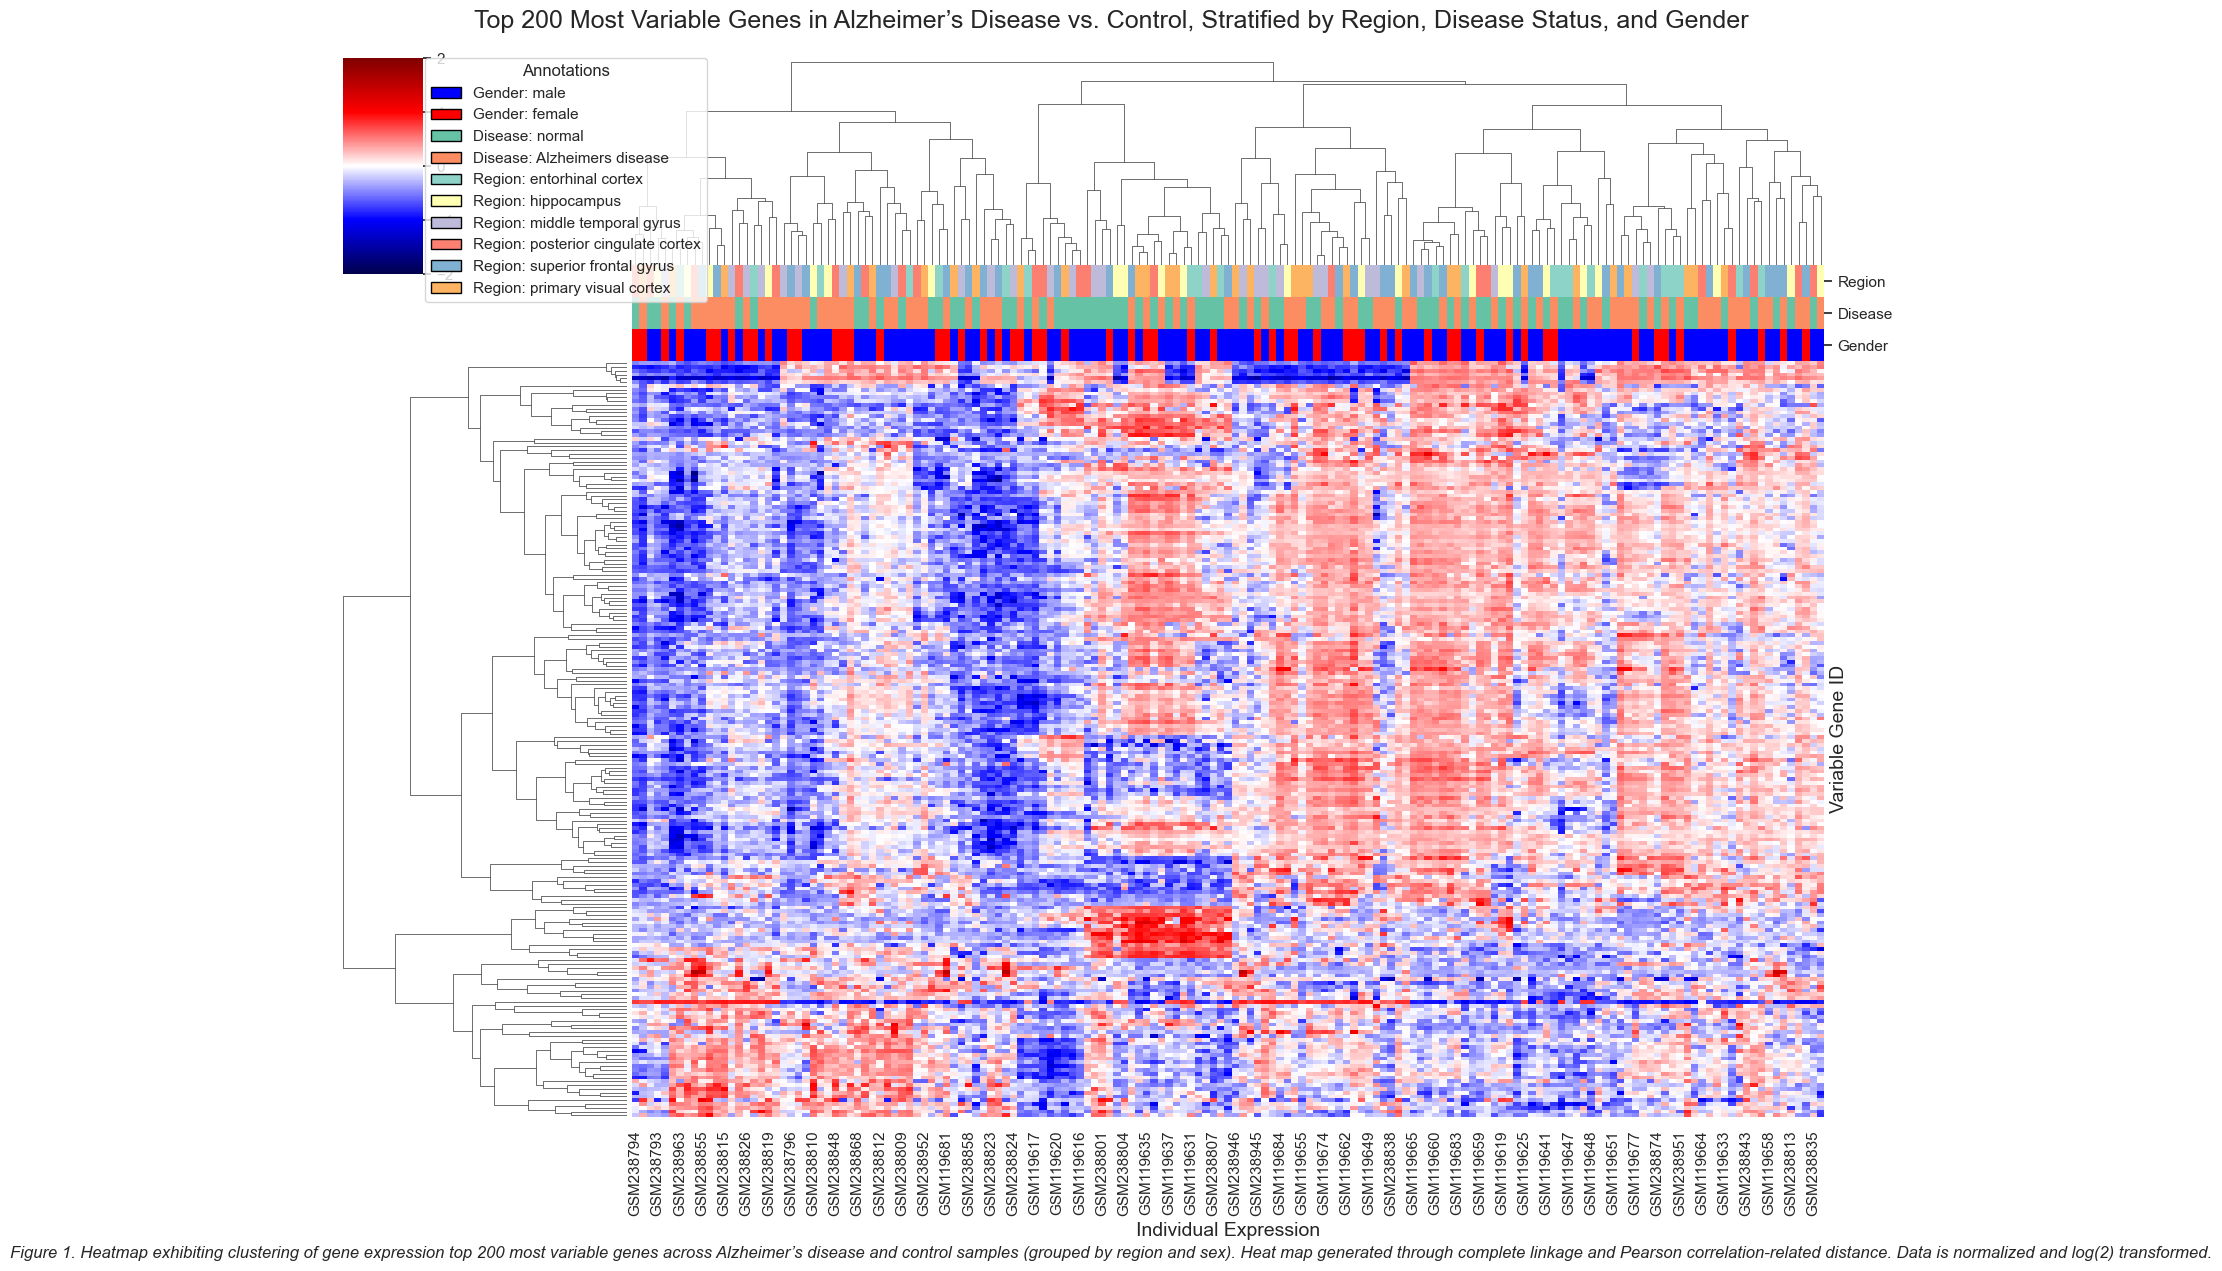

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib import colors as mcolors
from copy import copy

expr = pd.read_csv('ExpressionData.csv', delimiter=',')
expr = expr.rename(columns={expr.columns[0]: 'Gene_ID'})

expr.set_index('Gene_ID', inplace=True)

data = copy(expr.iloc[:, 2:])

# Drop rows with NaN or 0 values
data = data.dropna()
data = data[(data != 0).all(axis=1)]

data.columns = data.columns.str.strip()


data_row_norm = data.div(data.mean(axis=1), axis=0)
data_col_norm = data_row_norm.div(data_row_norm.mean(axis=1), axis=0)

# Log2 transform
data_log2 = np.log2(data_col_norm)
print(data_log2.columns)


metadata = pd.DataFrame({
    'Sample': data_log2.columns,
    'Region': annotations['Sample Characteristic[organism part]'].values,
    'Disease': annotations['Sample Characteristic[disease]'].values,
    'Gender': annotations['Sample Characteristic[sex]'].values,
})

metadata['Individual'] = np.arange(1, len(metadata)+1)


metadata.set_index('Sample', inplace=True)

region_colors = dict(zip(metadata['Region'].unique(), sns.color_palette('Set3', metadata['Region'].nunique())))
disease_colors = dict(zip(metadata['Disease'].unique(), sns.color_palette('Set2', metadata['Disease'].nunique())))
gender_colors = {'male': 'blue', 'female': 'red'}

individual_color_list = [mcolors.rgb2hex(c) for c in plt.cm.tab20.colors[:16]]
individual_colors = {i+1: individual_color_list[i % len(individual_color_list)] for i in range(len(metadata))}


col_region = metadata['Region'].map(region_colors)
col_disease = metadata['Disease'].map(disease_colors)
col_gender = metadata['Gender'].map(gender_colors)
col_individual = metadata['Individual'].map(individual_colors)

col_region = col_region.reindex(data_log2.columns)
col_disease = col_disease.reindex(data_log2.columns)
col_gender = col_gender.reindex(data_log2.columns)
col_individual = col_individual.reindex(data_log2.columns)

combined_column_colors = pd.DataFrame({
    'Region': col_region,
    'Disease': col_disease,
    'Gender': col_gender,
})

top_genes = data_log2.var(axis=1).sort_values(ascending=False).head(200).index
data_top = data_log2.loc[top_genes]

sns.set(style="white")
hm = sns.clustermap(data=data_top,
                    method='complete',
                    metric='correlation',
                    yticklabels=False,
                    vmin=-2,
                    vmax=2,
                    cmap='seismic',
                    col_colors=combined_column_colors,
                    figsize=(16, 12))

legend_handles = []

for label, color in gender_colors.items():
    legend_handles.append(Patch(facecolor=color, edgecolor='black', label=f'Gender: {label}'))

for label, color in disease_colors.items():
    legend_handles.append(Patch(facecolor=color, edgecolor='black', label=f'Disease: {label}'))

for label, color in region_colors.items():
    legend_handles.append(Patch(facecolor=color, edgecolor='black', label=f'Region: {label}'))

plt.legend(handles=legend_handles, title='Annotations', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)



hm.fig.suptitle('Top 200 Most Variable Genes in Alzheimer’s Disease vs. Control, Stratified by Region, Disease Status, and Gender', fontsize=18, y=1.02)
hm.ax_heatmap.set_xlabel('Individual Expression', fontsize=14)
hm.ax_heatmap.set_ylabel('Variable Gene ID', fontsize=14)

hm.fig.text(
    0.5,              
   -0.02,              
    'Figure 1. Heatmap exhibiting clustering of gene expression top 200 most variable genes across Alzheimer’s disease and control samples (grouped by region and sex). Heat map generated through complete linkage and Pearson correlation-related distance. Data is normalized and log(2) transformed.', 
    ha='center',    
    fontsize=12,
    style='italic'
)


plt.show()


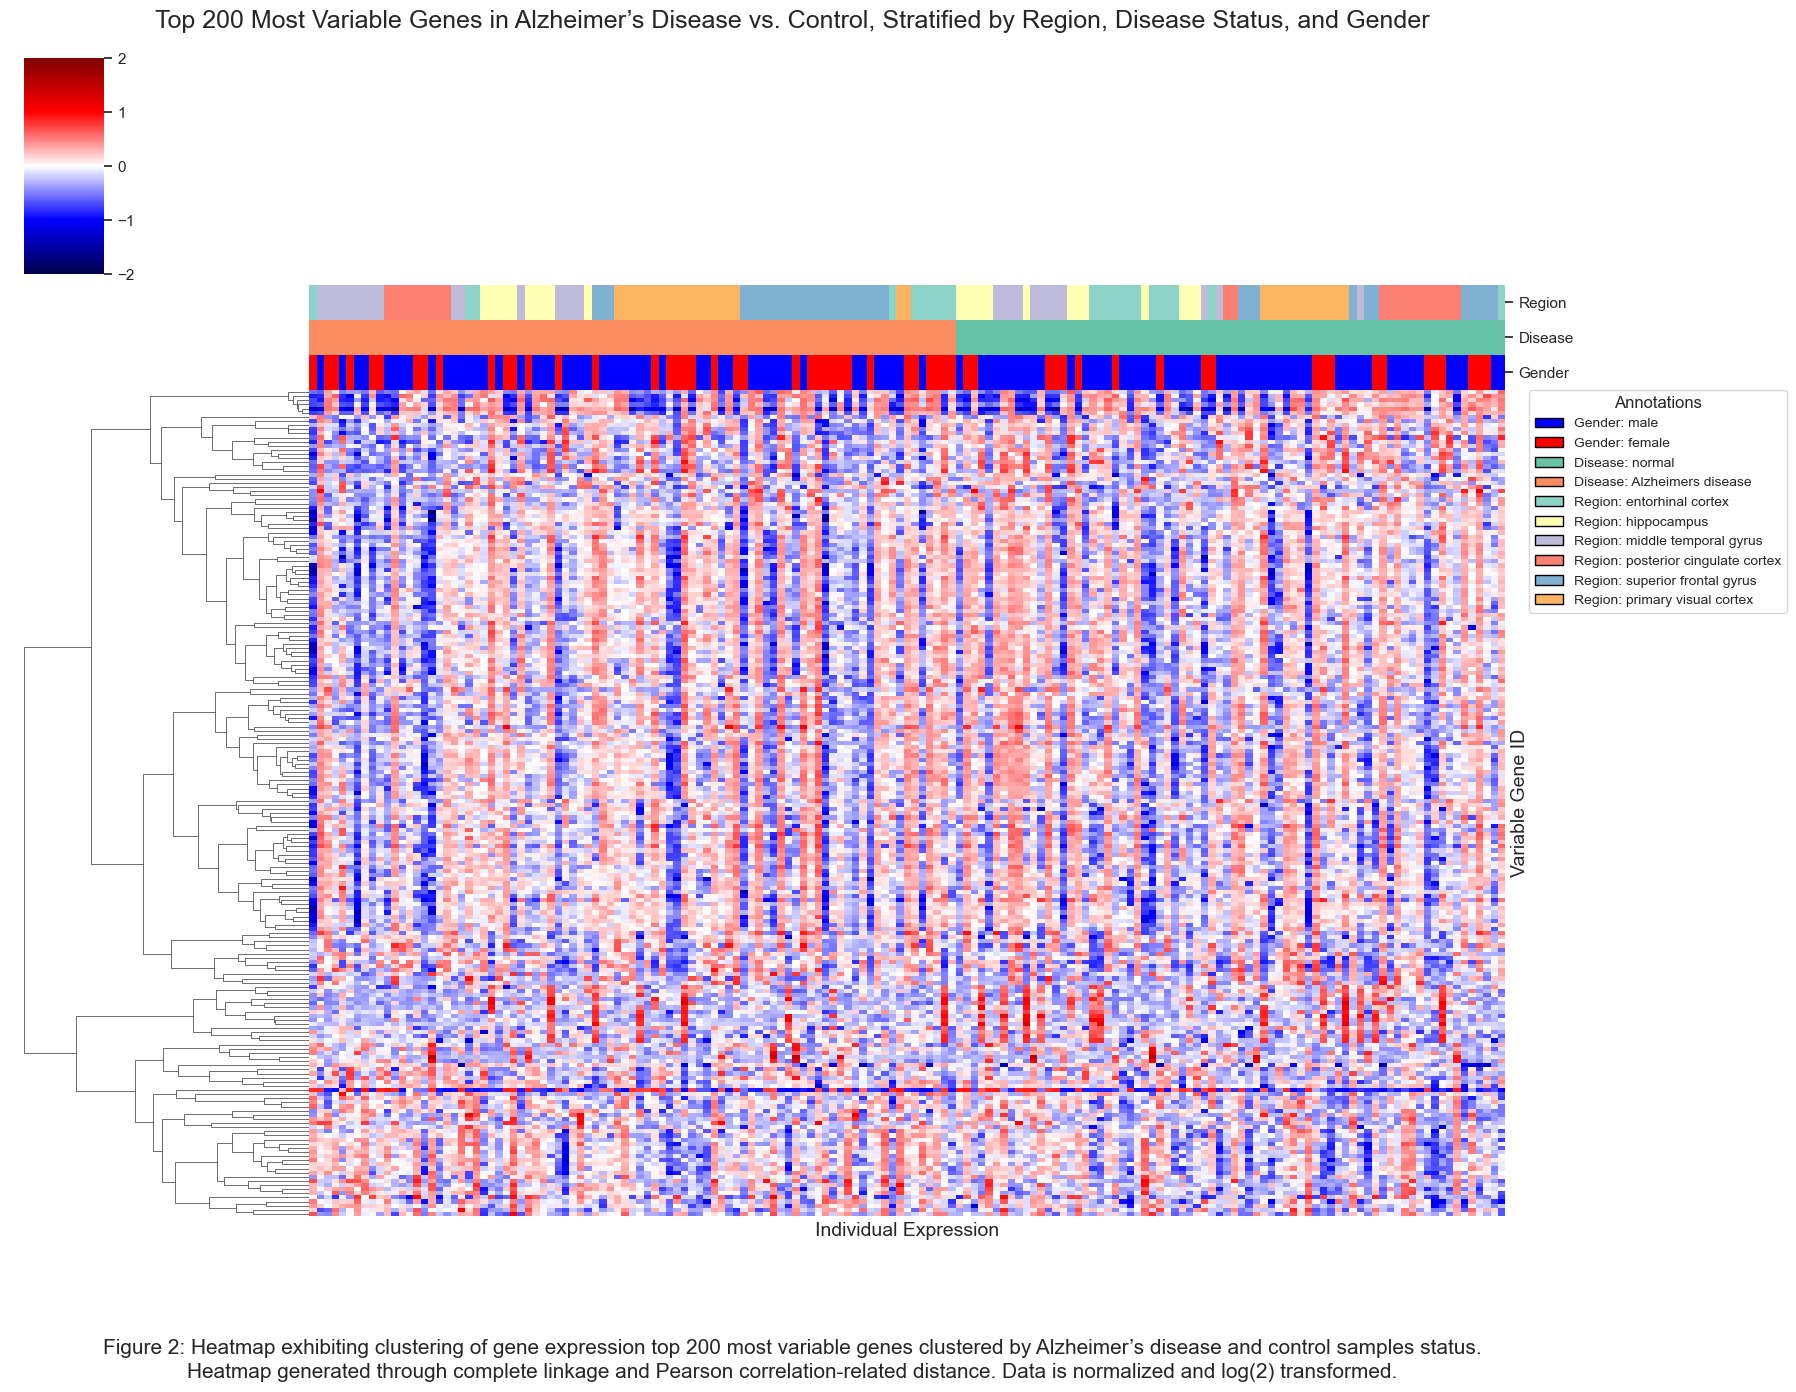

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib import colors as mcolors
from copy import copy


metadata = pd.DataFrame({
    'Sample': data_log2.columns,
    'Region': annotations['Sample Characteristic[organism part]'].values,
    'Disease': annotations['Sample Characteristic[disease]'].values,
    'Gender': annotations['Sample Characteristic[sex]'].values,
})


metadata['Individual'] = np.arange(1, len(metadata)+1)

metadata.set_index('Sample', inplace=True)


region_colors = dict(zip(metadata['Region'].unique(), sns.color_palette('Set3', metadata['Region'].nunique())))
disease_colors = dict(zip(metadata['Disease'].unique(), sns.color_palette('Set2', metadata['Disease'].nunique())))
gender_colors = {'male': 'blue', 'female': 'red'}


individual_color_list = [mcolors.rgb2hex(c) for c in plt.cm.tab20.colors[:16]]
individual_colors = {i+1: individual_color_list[i % len(individual_color_list)] for i in range(len(metadata))}

col_region = metadata['Region'].map(region_colors)
col_disease = metadata['Disease'].map(disease_colors)
col_gender = metadata['Gender'].map(gender_colors)
col_individual = metadata['Individual'].map(individual_colors)

col_region = col_region.reindex(data_log2.columns)
col_disease = col_disease.reindex(data_log2.columns)
col_gender = col_gender.reindex(data_log2.columns)
col_individual = col_individual.reindex(data_log2.columns)

# Combine into column color map
combined_column_colors = pd.DataFrame({
    'Region': col_region,
    'Disease': col_disease,
    'Gender': col_gender,
})

metadata_sorted = metadata.sort_values(by='Disease')
sorted_columns = metadata_sorted.index.tolist()
data_sorted = data_log2[sorted_columns]
col_colors_sorted = combined_column_colors.loc[sorted_columns]

top_genes = data_sorted.var(axis=1).sort_values(ascending=False).head(200).index
data_top = data_sorted.loc[top_genes]


sns.set(style="white")
hm = sns.clustermap(
    data=data_top,
    method='complete',
    metric='correlation',
    row_cluster=True,
    col_cluster=False, 
    yticklabels=False,
    xticklabels=False,
    vmin=-2,
    vmax=2,
    cmap='seismic',
    col_colors=col_colors_sorted,
    figsize=(16, 12)
)

hm.fig.suptitle('Top 200 Most Variable Genes in Alzheimer’s Disease vs. Control, Stratified by Region, Disease Status, and Gender', fontsize=18, y=1.02)

hm.ax_heatmap.set_xlabel('Individual Expression', fontsize=14)
hm.ax_heatmap.set_ylabel('Variable Gene ID', fontsize=14)

plt.figtext(0.5, -0.1, 'Figure 2: Heatmap exhibiting clustering of gene expression top 200 most variable genes clustered by Alzheimer’s disease and control samples status.', ha='center', fontsize=15) 
plt.figtext(0.5, -0.12, 'Heatmap generated through complete linkage and Pearson correlation-related distance. Data is normalized and log(2) transformed.', ha='center', fontsize=15) 

from matplotlib.patches import Patch

# === Build legend handles ===
legend_handles = []

# Gender legend
for label, color in gender_colors.items():
    legend_handles.append(Patch(facecolor=color, edgecolor='black', label=f'Gender: {label}'))

# Disease legend
for label, color in disease_colors.items():
    legend_handles.append(Patch(facecolor=color, edgecolor='black', label=f'Disease: {label}'))

# Region legend
for label, color in region_colors.items():
    legend_handles.append(Patch(facecolor=color, edgecolor='black', label=f'Region: {label}'))

# === Add legend to figure ===
hm.ax_heatmap.legend(
    handles=legend_handles,
    title='Annotations',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    fontsize='small',
    title_fontsize='medium'
)

plt.show()



In [6]:
region1_samples = annotations[
    (annotations['Sample Characteristic[organism part]'] == 'hippocampus') &
    (annotations['Sample Characteristic[disease]'] == 'Alzheimers disease')
].index

region2_samples = annotations[
    (annotations['Sample Characteristic[organism part]'] == 'primary visual cortex') &
    (annotations['Sample Characteristic[disease]'] == 'Alzheimers disease')
].index

region1_samples = [s for s in region1_samples if s in data_log2.columns]
region2_samples = [s for s in region2_samples if s in data_log2.columns]



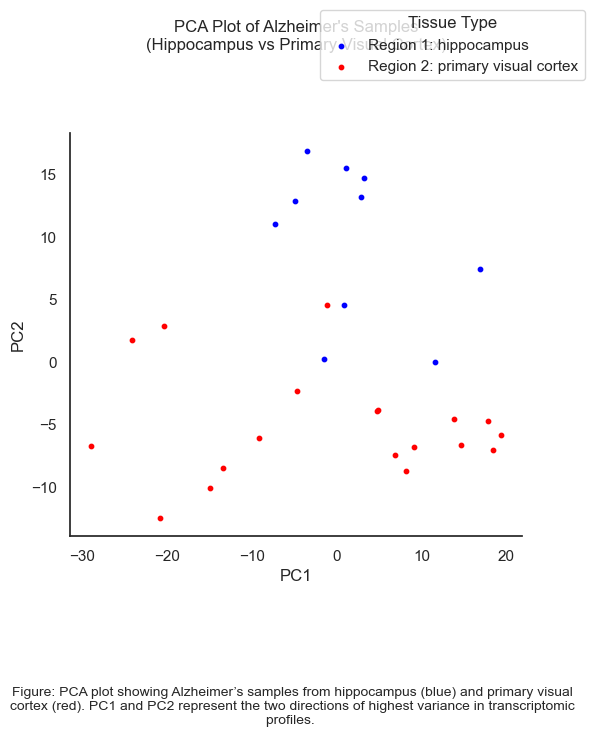

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

annotations.set_index('Assay', inplace=True)
annotations.index = annotations.index.astype(str).str.strip()
data_log2.columns = data_log2.columns.astype(str).str.strip()


region1 = "hippocampus"
region2 = "primary visual cortex"


alz_annotations = annotations[
    annotations['Sample Characteristic[disease]'] == 'Alzheimers disease'
]

region1_samples = alz_annotations[
    alz_annotations['Sample Characteristic[organism part]'] == region1
].index

region2_samples = alz_annotations[
    alz_annotations['Sample Characteristic[organism part]'] == region2
].index

region1_samples = [s for s in region1_samples if s in data_log2.columns]
region2_samples = [s for s in region2_samples if s in data_log2.columns]


selected_samples = region1_samples + region2_samples
subset_data = data_log2[selected_samples].T  

labels = ['Region 1: ' + region1] * len(region1_samples) + ['Region 2: ' + region2] * len(region2_samples)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(subset_data)


pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=subset_data.index)
pca_df['Region'] = labels


plt.figure(figsize=(6, 6))

colors = {
    'Region 1: ' + region1: 'blue',
    'Region 2: ' + region2: 'red'
}

for region_label in pca_df['Region'].unique():
    subset = pca_df[pca_df['Region'] == region_label]
    plt.scatter(subset['PC1'], subset['PC2'], label=region_label, c=colors[region_label], s=10)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'PCA Plot of Alzheimer\'s Samples\n({region1.title()} vs {region2.title()})', pad=60)
plt.legend(title='Tissue Type', bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)

# Caption
caption = (
    f"Figure: PCA plot showing Alzheimer’s samples from {region1} (blue) and {region2} (red). "
    "PC1 and PC2 represent the two directions of highest variance in transcriptomic profiles. "
)
plt.figtext(0.5, -0.2, caption, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()
plt.show()


/var/folders/q7/hn874wbn06b0h6s45zm5f6bw0000gn/T/ipykernel_8395/335806509.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', title='Gene Significance', frameon=False)


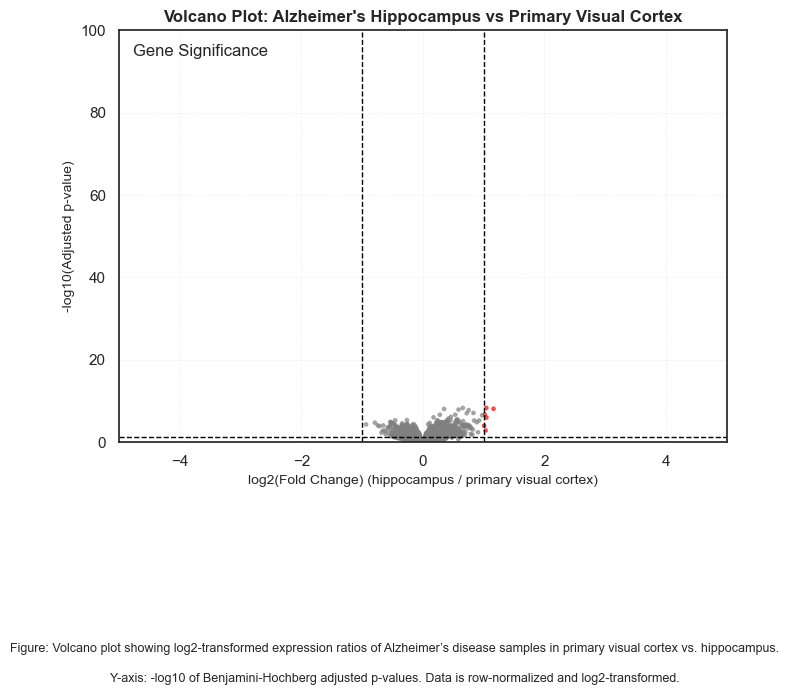

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

annotations.index = annotations.index.astype(str).str.strip()
data_log2.columns = data_log2.columns.astype(str).str.strip()

region1 = "hippocampus"
region2 = "primary visual cortex"

alz_annotations = annotations[
    annotations['Sample Characteristic[disease]'] == 'Alzheimers disease'
]

region1_samples = alz_annotations[
    alz_annotations['Sample Characteristic[organism part]'] == region1
].index

region2_samples = alz_annotations[
    alz_annotations['Sample Characteristic[organism part]'] == region2
].index


region1_samples = [s for s in region1_samples if s in data_log2.columns]
region2_samples = [s for s in region2_samples if s in data_log2.columns]



region1_expr = data_log2[region1_samples]
region2_expr = data_log2[region2_samples]


log2FC = region1_expr.mean(axis=1) - region2_expr.mean(axis=1)

# Welch's t-test (gene-by-gene)
p_values = []
valid_genes = []

for gene in data_log2.index:
    if gene in region1_expr.index and gene in region2_expr.index:
        vals1 = region1_expr.loc[gene].dropna().values
        vals2 = region2_expr.loc[gene].dropna().values
        if len(vals1) > 1 and len(vals2) > 1:
            try:
                _, pval = ttest_ind(vals1, vals2, equal_var=False)
                p_values.append(float(pval))  # ensure scalar
                valid_genes.append(gene)
            except:
                continue

p_adjusted = multipletests(p_values, method='fdr_bh')[1]
p_adjusted = np.maximum(p_adjusted, 1e-300)
neg_log10_p = -np.log10(p_adjusted)

volcano_df = pd.DataFrame({
    'log2FC': log2FC.loc[valid_genes],
    '-log10(p_adj)': neg_log10_p
}, index=valid_genes)

volcano_df['Significance'] = 'Not Significant'
volcano_df.loc[(p_adjusted <= 0.05) & (abs(volcano_df['log2FC']) >= 1), 'Significance'] = 'Significant'

colors = {'Significant': 'red', 'Not Significant': 'gray'}

plt.figure(figsize=(7, 6))
plt.scatter(volcano_df['log2FC'], volcano_df['-log10(p_adj)'],
            c=volcano_df['Significance'].map(colors), s=6, alpha=0.6)


plt.axhline(-np.log10(0.05), linestyle='dashed', color='black', linewidth=1)
plt.axvline(-1, linestyle='dashed', color='black', linewidth=1)
plt.axvline(1, linestyle='dashed', color='black', linewidth=1)


plt.xlabel(f'log2(Fold Change) ({region1} / {region2})', fontsize=10)
plt.ylabel('-log10(Adjusted p-value)', fontsize=10)
plt.title(f'Volcano Plot: Alzheimer\'s {region1.title()} vs {region2.title()}', fontsize=12, weight='bold')
plt.xlim(-5, 5)
plt.ylim(0, 100)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
plt.legend(loc='upper left', title='Gene Significance', frameon=False)


plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  

plt.figtext(0.5, -0.10, 
            'Figure: Volcano plot showing log2-transformed expression ratios of Alzheimer’s disease samples in primary visual cortex vs. hippocampus.', 
            ha='center', fontsize=9)

plt.figtext(0.5, -0.15, 
            'Y-axis: -log10 of Benjamini-Hochberg adjusted p-values. Data is row-normalized and log2-transformed.', 
            ha='center', fontsize=9)
plt.show()


In [139]:
# Reset index so we can drop duplicates based on Gene_ID
expr_reset = expr.reset_index()

# Drop duplicates based on Gene_ID (first appearance kept)
expr_unique = expr_reset.drop_duplicates(subset='Gene_ID', keep='first')

# Now make the mapping: Gene_ID ➝ Gene_Name
gene_id_to_name = pd.Series(expr_unique['Gene Name'].values, index=expr_unique['Gene_ID'])

# Map Gene_ID ➝ Gene_Name
volcano_df['Gene_Name'] = volcano_df.index.map(gene_id_to_name)

# Drop rows with missing or duplicate gene names
volcano_df = volcano_df.dropna(subset=['Gene_Name'])
volcano_df = volcano_df.drop_duplicates(subset=['Gene_Name'])

# Set gene name as index
volcano_df.set_index('Gene_Name', inplace=True)

# Get top 1000 downregulated gene names
downregulated = volcano_df[(volcano_df['log2FC'] < 0)].sort_values(by='log2FC')
top_1000_down = downregulated.head(1000).index.tolist()

import gseapy as gp

enr_down = gp.enrichr(
    gene_list=top_1000_down,
    gene_sets='KEGG_2021_Human',
    organism='Human',
    outdir=None,
    cutoff=0.05
)

# Show top 10 enriched KEGG pathways
enrichment_down_results = enr_down.results.sort_values(by='Adjusted P-value').head(10)
print(enrichment_down_results[['Term', 'Overlap', 'Adjusted P-value', 'Combined Score']])


                                   Term Overlap  Adjusted P-value  \
0                         Axon guidance  25/182          0.001227   
1                    Pathways in cancer  50/531          0.001886   
2       Adipocytokine signaling pathway   12/69          0.013396   
3            Non-small cell lung cancer   11/72          0.059254   
7             Calcium signaling pathway  23/240          0.068356   
6                MAPK signaling pathway  27/294          0.068356   
8                    Endometrial cancer    9/58          0.068356   
4                Gastric acid secretion   11/76          0.068356   
5  Leukocyte transendothelial migration  14/114          0.068356   
9                    Insulin resistance  13/108          0.076741   

   Combined Score  
0       37.957216  
1       22.718810  
2       35.703919  
3       24.417154  
7       12.472511  
6       12.319712  
8       21.485446  
4       21.426248  
5       17.190728  
9       15.360381  
